## Saâd AZIZ ALAOUI & Simoné IANNELLI
## MATHSAPPS BAYES MICE

In [1]:
import numpy as np
from numpy.random import normal
from scipy.stats import weibull_min, logistic, norm, gamma, expon, truncweibull_min
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Vecteur des failure times (les individus censurés ont un nan)
t =np.array([12,17,21, 25, 11,  26,  27,  30, 13, 12,  21,20,  23,  25,  23,  29, 35, np.nan, 31, 36,
     32, 27,  23, 12, 18, np.nan, np.nan,  38, 29, 30, np.nan, 32, np.nan, np.nan, np.nan, np.nan, 25,  30, 37, 27,
     22, 26, np.nan, 28, 19,  15,  12,  35, 35, 10,  22, 18, np.nan,  12, np.nan, np.nan, 31,  24, 37, 29,
     27, 18,  22, 13, 18,  29,  28, np.nan, 16, 22,  26, 19, np.nan, np.nan,  17,  28, 26,  12, 17, 26])
# les individus censurés ont une valeur différente de zéro (leur temps de censure en semaines)
tcensor =np.array([0, 0,  0, 0, 0,  0,  0,  0, 0, 0,  0, 0,  0,  0,  0,  0, 0, 40, 0, 0,
     0, 0,  0, 0, 0, 40, 40,  0, 0, 0, 40, 0, 40, 40, 40, 40, 0,  0, 0, 0,
     0, 0, 10, 0, 0,  0,  0,  0, 0, 0,  0, 0, 24,  0, 40, 40, 0,  0, 0, 0,
     0, 0,  0, 0, 0,  0,  0, 20, 0, 0,  0, 0, 29, 10,  0,  0, 0,  0, 0, 0])

is_censored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 
0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 
0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

t_uncensored =np.array([12, 17, 21, 25, 11, 26, 27, 30, 13, 12, 21, 20, 23, 25, 23, 
29, 35, 31, 36, 32, 27, 23, 12, 18, 38, 29, 30, 32, 25, 30, 37, 
27, 22, 26, 28, 19, 15, 12, 35, 35, 10, 22, 18, 12, 31, 24, 37, 
29, 27, 18, 22, 13, 18, 29, 28, 16, 22, 26, 19, 17, 28, 26, 12, 
17, 26])

group_mice = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 
3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

len_uncens = len(t_uncensored)
len_cens = 80 - len_uncens
len_group = 4

In [12]:
init_r = 1 
init_beta1 = -1
init_beta2 = -1
init_beta3 = -1
init_beta4 = -1
init_vehcontrol = 0
init_testsub = 0
init_poscontrol = 0

In [13]:
def dens_weib(k,lamb,data) : 

    dens = (k-1) * np.log(np.array(data)/lamb) -((np.array(data)/lamb)**k)

    return dens 

def survie_weib(k,lamb,data) : 

    dens = -((np.array(data)/lamb)**k)

    return dens 

In [14]:
def mice(nchain,init_r,init_beta1,init_beta2,init_beta3,init_beta4,init_vehcontrol,init_testsub,init_poscontrol,prop_sd,t,tcen) :

    ## nchain est la taille de la chaine 
    ## init_alpha, init_beta1, init_beta2,init_beta3,init_beta4,init_vehcontrol,init_testsub,init_poscontrol sont les val init de nos param
    ## prop_sd est la variance pour la MC
    ## la fonction résoud le probleme WINBUGS MICE MCMC within GIBBS.

    r = init_r
    beta1 = init_beta1
    beta2 = init_beta2
    beta3 = init_beta3
    beta4 = init_beta4
    veh_control = init_vehcontrol
    testsub = init_testsub
    poscontrol = init_poscontrol	


    chain = np.zeros((nchain+1, 8))
    acc_rate = np.zeros(5)
    chain[0,0] = init_r
    chain[0,1] = init_beta1
    chain[0,2] = init_beta2
    chain[0,3] = init_beta3
    chain[0,4] = init_beta4
    chain[0,5] = init_vehcontrol
    chain[0,6] = init_testsub
    chain[0,7] = init_poscontrol

    t_1 = t[:20] 
    tcen_1 = tcen[:20]
    is_censored_1 = is_censored[:20]
    uncensored_array_1 = [t_1[i] for i in range(len(t_1)) if is_censored_1[i] == 0]
    censored_array_1 = [tcen_1[i] for i in range(len(tcen_1)) if is_censored_1[i] == 1]

    t_2 = t[20:40]
    tcen_2 = tcen[20:40]
    is_censored_2 = is_censored[20:40]
    uncensored_array_2 = [t_2[i] for i in range(len(t_2)) if is_censored_2[i] == 0]
    censored_array_2 = [tcen_2[i] for i in range(len(tcen_2)) if is_censored_2[i] == 1]

    t_3= t[40:60]
    tcen_3 = tcen[40:60]
    is_censored_3 = is_censored[40:60]
    uncensored_array_3 = [t_3[i] for i in range(len(t_3)) if is_censored_3[i] == 0]
    censored_array_3 = [tcen_3[i] for i in range(len(tcen_3)) if is_censored_3[i] == 1]

    t_4 = t[60:80]
    tcen_4 = tcen[60:80]
    is_censored_4 = is_censored[60:80]
    uncensored_array_4 = [t_4[i] for i in range(len(t_4)) if is_censored_4[i] == 0]
    censored_array_4 = [tcen_4[i] for i in range(len(tcen_4)) if is_censored_4[i] == 1]
    
    for i in range(nchain) : 

        # Mise à jour de r pour commencer 

        prop = normal(loc = r, scale = prop_sd[0])
        top = (-10**-3)*prop + sum(dens_weib(prop,np.exp(-beta1/prop),uncensored_array_1)) + sum(dens_weib(prop,np.exp(-beta2/prop),uncensored_array_2)) + sum(dens_weib(prop,np.exp(-beta3/prop),uncensored_array_3)) + sum(dens_weib(prop,np.exp(-beta4/prop),uncensored_array_4))
        top = top + sum(survie_weib(prop,np.exp(-beta1/prop),censored_array_1)) + sum(survie_weib(prop,np.exp(-beta2/prop),censored_array_2)) + sum(survie_weib(prop,np.exp(-beta3/prop),censored_array_3)) + sum(survie_weib(prop,np.exp(-beta4/prop),censored_array_4))


        bottom = (-10**-3)*r + sum(dens_weib(r,np.exp(-beta1/r),uncensored_array_1)) + sum(dens_weib(r,np.exp(-beta2/r),uncensored_array_2)) + sum(dens_weib(r,np.exp(-beta3/r),uncensored_array_3)) + sum(dens_weib(r,np.exp(-beta4/r),uncensored_array_4))
        bottom = bottom + sum(survie_weib(r,np.exp(-beta1/r),censored_array_1)) + sum(survie_weib(r,np.exp(-beta2/r),censored_array_2)) + sum(survie_weib(r,np.exp(-beta3/r),censored_array_3)) + sum(survie_weib(r,np.exp(-beta4/r),censored_array_4))

        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            r = prop
            acc_rate[0] += 1

        # Mise à jour de Beta 1 
        prop = normal(loc = beta1, scale = prop_sd[1])
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop/r),uncensored_array_1)) + sum(survie_weib(r,np.exp(-prop/r),censored_array_1))
        bottom = - (beta1**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta1/r),uncensored_array_1)) + sum(survie_weib(r,np.exp(-beta1/r),censored_array_1))
        acc_prob = np.exp(top - bottom)
        
        if np.random.uniform() < acc_prob:
            beta1 = prop
            acc_rate[1] += 1

        median1 = (np.log(2) * np.exp(-beta1)) ** 1/r

        # Mise à jour de Beta 2
        prop = normal(loc = beta2, scale = prop_sd[2])
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop/r),uncensored_array_2)) + sum(survie_weib(r,np.exp(-prop/r),censored_array_2))
        bottom = - (beta2**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta2/r),uncensored_array_2)) + sum(survie_weib(r,np.exp(-beta2/r),censored_array_2))
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            beta2 = prop
            acc_rate[2] += 1
        # print(beta2) 
        median2 = (np.log(2) * np.exp(-beta2)) ** 1/r

        # Mise à jour de Beta 3
        prop = normal(loc = beta3, scale = prop_sd[3])
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop/r),uncensored_array_3)) + sum(survie_weib(r,np.exp(-prop/r),censored_array_3))
        bottom = - (beta3**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta3/r),uncensored_array_3)) + sum(survie_weib(r,np.exp(-beta3/r),censored_array_3))
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            beta3 = prop
            acc_rate[2] += 1
        # print(beta3) 
        median3 = (np.log(2) * np.exp(-beta3)) ** 1/r

        # Mise à jour de Beta 4
        prop = normal(loc = beta4, scale = prop_sd[4])
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop/r),uncensored_array_4)) + sum(survie_weib(r,np.exp(-prop/r),censored_array_4))
        bottom = - (beta4**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta4/r),uncensored_array_4)) + sum(survie_weib(r,np.exp(-beta4/r),censored_array_4))
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            beta4 = prop
            acc_rate[3] += 1

        median4 = (np.log(2) * np.exp(-beta4)) ** 1/r

        vehcontrol = beta2 - beta1
        testsub = beta3 -  beta1
        poscontrol = beta4 - beta1
        chain[i+1,:] = np.array([r, beta1, beta2, beta3, beta4, vehcontrol, testsub, poscontrol ])


    return(chain,acc_rate)



In [15]:
chain, acc_rate = mice(13000, init_r, init_beta1, init_beta2, init_beta3,init_beta4,init_vehcontrol,init_testsub,
                       init_poscontrol, np.array([0.1,0.1, 0.1, 0.11, 0.1]),t,tcensor)

C:\Users\saada\AppData\Local\Temp\ipykernel_11124\3614809796.py:65: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\3614809796.py:75: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\3614809796.py:99: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\3614809796.py:111: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\3614809796.py:87: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(top - bottom)
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\411974577.py:3: RuntimeWarning: overflow encountered in divide
  dens = (k-1) * np.log(np.array(data)/lamb) -((np.array(data)/lamb)**k)
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\411974577.py:9: RuntimeWarning: o

Text(0.5, 1.0, 'variations de r')

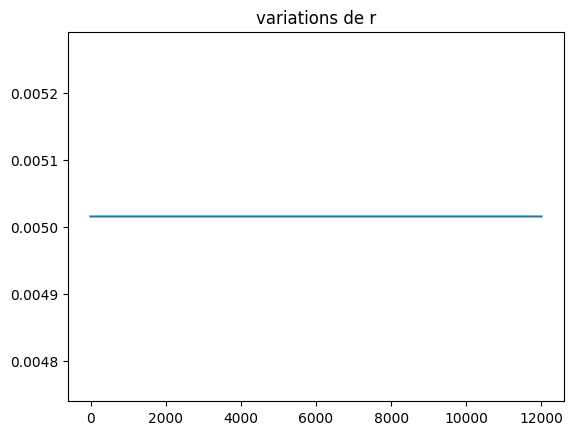

In [16]:
plt.plot(chain[:,0][1000:]) # on retire les 1000 premières itérations (burn-in)
plt.title("variations de r")

In [17]:
print("Le taux d'acceptation de r :" + str(acc_rate[0] / 100) + "%")
mean_r = np.mean(chain[:,0])
print("La moyenne empirique de r :" + str(mean_r))
sd_r = np.std(chain[:,0])
print("L'écart-type empirique de r :" + str(sd_r))

Le taux d'acceptation de r :0.42%
La moyenne empirique de r :0.01374983990109369
L'écart-type empirique de r :0.1276805195393314


In [18]:
print("Le taux d'acceptation de beta1 :" + str(acc_rate[1] / 100) + "%")
mean_beta1 = np.mean(chain[:,1])
print("La moyenne empirique de beta1 :" + str(mean_beta1))
sd_beta1 = np.std(chain[:,1])
print("L'écart-type empirique de beta1 :" + str(sd_beta1))

Le taux d'acceptation de beta1 :0.84%
La moyenne empirique de beta1 :-6.129606913143816
L'écart-type empirique de beta1 :0.47254287175237064


C:\Users\saada\AppData\Local\Temp\ipykernel_11124\2281753883.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  p = sns.kdeplot(ax=axs[0,1], data=chain[:,0][1000:])
C:\Users\saada\AppData\Local\Temp\ipykernel_11124\2281753883.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axs[2,1], data=chain[:,2][1000:]).set_ylabel("")


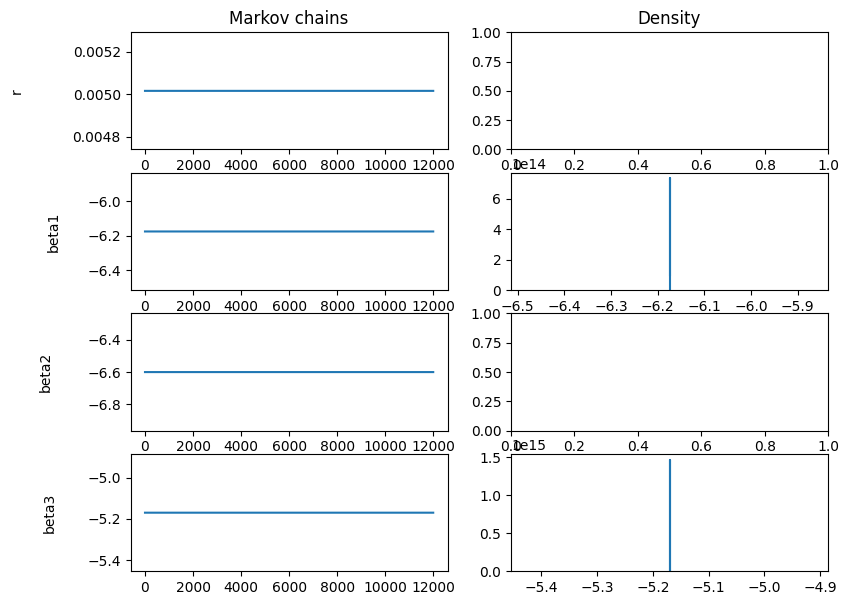

In [19]:
fig, axs = plt.subplots(4, 2, figsize = (9,7))
axs[0, 0].plot(chain[:,0][1000:])
axs[0, 0].set_ylabel('r', labelpad = 35)
axs[0, 0].set_title('Markov chains')
p = sns.kdeplot(ax=axs[0,1], data=chain[:,0][1000:])
p.set_ylabel("")
p.set_title("Density")
axs[1, 0].plot(chain[:,1][1000:])
axs[1, 0].set_ylabel('beta1', labelpad = 19)
sns.kdeplot(ax=axs[1,1], data=chain[:,1][1000:]).set_ylabel("")
axs[2, 0].plot(chain[:,2][1000:])
axs[2, 0].set_ylabel('beta2', labelpad = 25)
sns.kdeplot(ax=axs[2,1], data=chain[:,2][1000:]).set_ylabel("")
axs[3, 0].plot(chain[:,3][1000:])
axs[3, 0].set_ylabel('beta3', labelpad = 22)
sns.kdeplot(ax=axs[3,1], data=chain[:,3][1000:]).set_ylabel("");